<a href="https://colab.research.google.com/github/NimaTB/data-science-road-map/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is my practice to learn the basics of how chatGBT works. The code is from [micrograd github repo](https://github.com/karpathy/micrograd) developed by [Andrej Karpathy](https://karpathy.ai/) with some additional notes and useful links that furhter help ML and Data Science enthusiast who are eager to learn. Check this youtube video [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1). 

In [111]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
def f(x):
  return 3*x**2 - 4*x +5

In [113]:
f(3.0)

20.0

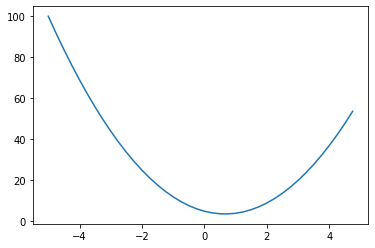

In [114]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [115]:
h = 0.00001
x = 3.0
( f(x+h) - f(x) ) / h 

14.00003000000538

In [116]:
h = 0.00001
x = -3.0
( f(x+h) - f(x) ) / h 

-21.999970000052823

In [117]:
h = 0.00001
x = 2/3
( f(x+h) - f(x) ) / h 

3.0000002482211127e-05

In [118]:
# More complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [119]:
h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
# b += h
# c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', ((d2 - d1)/h))

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


Skleton of building a value object

More details on [`__repr__`](https://www.programiz.com/python-programming/methods/built-in/repr)

In [120]:
class Value_v1:
  
  def __init__(self, data):
    self.data = data

  def __repr__(self): 
    return f"Value_v1(data={self.data})"

  def __add__(self, other):
    out = Value_v1(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value_v1(self.data * other.data)
    return out
    

In [121]:
a = Value_v1(2.0)
b = Value_v1(-3.0)
c = Value_v1(10.0)
print('a + b: What happens internally is a.__add__(b) =  ', str(a + b)) 
print('a * b: What happens internally is a.__mul__(b) =  ', str(a * b)) 

a + b: What happens internally is a.__add__(b) =   Value_v1(data=-1.0)
a * b: What happens internally is a.__mul__(b) =   Value_v1(data=-6.0)


In [122]:
d = a * b + c

In [123]:
class Value_v2:
  
  def __init__(self, data, _children=()):
    self.data = data
    self._prev = set(_children)

  def __repr__(self): 
    return f"Value_v2(data={self.data})"

  def __add__(self, other):
    out = Value_v2(self.data + other.data, (self, other))
    return out

  def __mul__(self, other):
    out = Value_v2(self.data * other.data, (self, other))
    return out

In [124]:
a = Value_v2(2.0)
b = Value_v2(-3.0)
c = Value_v2(10.0)

d = a * b + c
d._prev

{Value_v2(data=-6.0), Value_v2(data=10.0)}

In [125]:
class Value_v3:
  
  def __init__(self, data, _children=(), _op = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self): 
    return f"Value_v3(data={self.data})"

  def __add__(self, other):
    out = Value_v3(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value_v3(self.data * other.data, (self, other), '*')
    return out

In [126]:
a = Value_v3(2.0)
b = Value_v3(-3.0)
c = Value_v3(10.0)

d = a * b + c
print(d._prev)
print(d._op)

{Value_v3(data=10.0), Value_v3(data=-6.0)}
+


In [127]:
from graphviz import Digraph
def trace(root):
  # Building a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: left to right  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "data %.4f" % (n.data, ), shape='record')
    if n._op:
      # If this value is a result of some operation, create an op node for it 
      dot.node(name = uid + n._op, label = n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # Connect n1 to the op node of n_2
    dot.edge(str(id(n1)), str(id(n2))+ n2._op)

  return dot
  

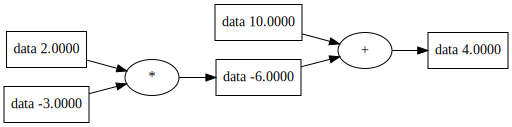

In [128]:
draw_dot(d)

Adding labels to the objects

In [129]:
class Value_v4:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value_v4(data={self.data})"

  def __add__(self, other):
    out = Value_v4(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value_v4(self.data * other.data, (self, other), '*')
    return out

Changin draw_dot function accordingly to include labels

In [130]:
from graphviz import Digraph
def trace(root):
  # Building a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: left to right  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f}" % (n.label, n.data ), shape='record')
    if n._op:
      # If this value is a result of some operation, create an op node for it 
      dot.node(name = uid + n._op, label = n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # Connect n1 to the op node of n_2
    dot.edge(str(id(n1)), str(id(n2))+ n2._op)

  return dot
  

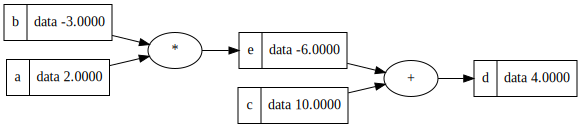

In [131]:
a = Value_v4(2.0, label='a')
b = Value_v4(-3.0, label='b')
c = Value_v4(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
draw_dot(d)

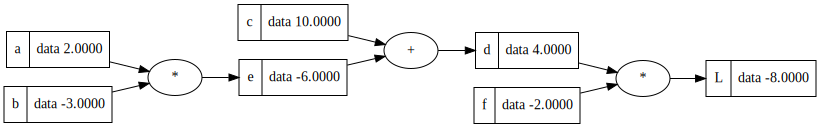

In [132]:
a = Value_v4(2.0, label='a')
b = Value_v4(-3.0, label='b')
c = Value_v4(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value_v4(-2.0, label='f')
L = d*f; L.label = 'L'
draw_dot(L)

In the following, we will add the gradient object in the Value to store the result of the backpropagation (calculating the derivatives of L, w.r.t. to a,b, ...)

In [133]:
class Value_v5:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value_v5(data={self.data})"

  def __add__(self, other):
    out = Value_v5(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value_v5(self.data * other.data, (self, other), '*')
    return out

Adding grad in the draw_dot function 

In [134]:
def trace(root):
  # Building a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: left to right  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # If this value is a result of some operation, create an op node for it 
      dot.node(name = uid + n._op, label = n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # Connect n1 to the op node of n_2
    dot.edge(str(id(n1)), str(id(n2))+ n2._op)

  return dot

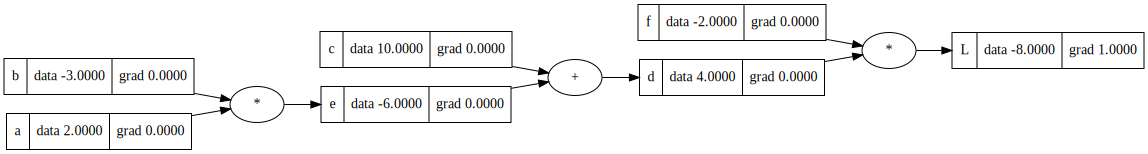

In [135]:
a = Value_v5(2.0, label='a')
b = Value_v5(-3.0, label='b')
c = Value_v5(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value_v5(-2.0, label='f')
L = d*f; L.label = 'L'
L.grad = 1
draw_dot(L)


Backpropagation and derivative idea
$L = d * f$

$\frac{dL}{dd} = ?$

$\frac{g(x+h) - g(x)}{h} = \frac{(d+h)*f - d*f}{h} = f$

now what is $\frac{dd}{dc} ? $

$d = c + e$ 

$\frac{g(x+h) - g(x)}{h} = \frac{(c+h)+e - c+e}{h} = 1$


what is $\frac{dd}{de} ? $

$\frac{g(x+h) - g(x)}{h} = \frac{c+(e+h) - c+e}{h} = 1$

But what we are looking for here is to find $\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $


$e = a * b$ 
Next we want $\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} $

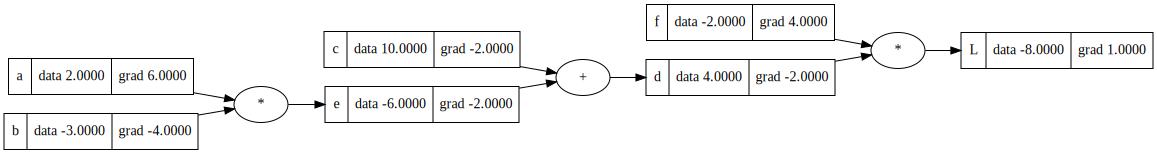

In [136]:

a = Value_v5(2.0, label='a')
b = Value_v5(-3.0, label='b')
c = Value_v5(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value_v5(-2.0, label='f')
L = d*f; L.label = 'L'
L.grad = 1
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)
draw_dot(L)

We can verify the above derivatives by adding h to any variable $v_{temp}$ to compute $\frac{dL}{d v_{temp}}$

In [137]:
def lol():
  h = 0.0001
  a = Value_v5(2.0, label='a')
  b = Value_v5(-3.0, label='b')
  c = Value_v5(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value_v5(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data # L is a Value node, so we want its data


  a = Value_v5(2.0, label='a')
  # a.data += h
  b = Value_v5(-3.0, label='b')
  # b.data += h
  c = Value_v5(10.0, label='c')
  # c.data += h
  e = a * b; e.label = 'e'
  # e.data += h
  d = e + c; d.label = 'd'
  # d.data += h
  f = Value_v5(-2.0, label='f')
  # f.data += h

  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


Forward Pass

In [138]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


**adding exponent into the `Value` class**

In [139]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

Building neurons 

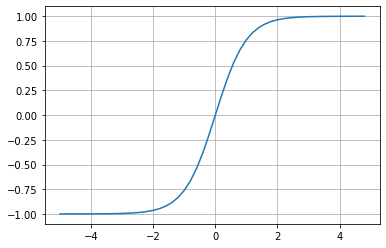

In [140]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

Example 1 to see the impact of tanh

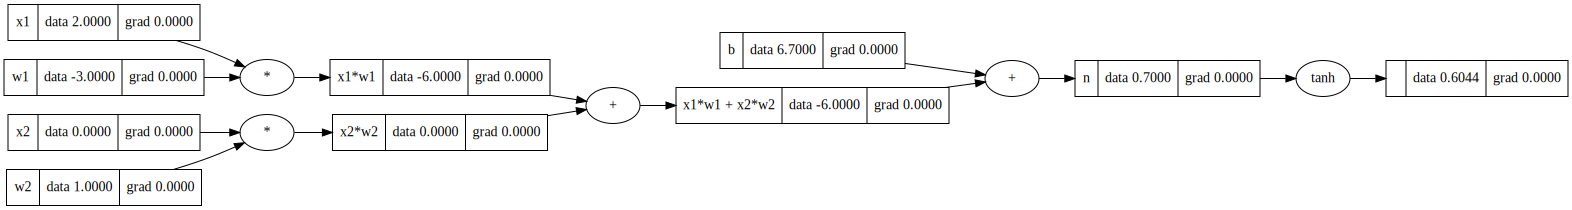

In [141]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
# draw_dot(n)
draw_dot(o)

Example 2 by changing the bias to see the impact of tanh

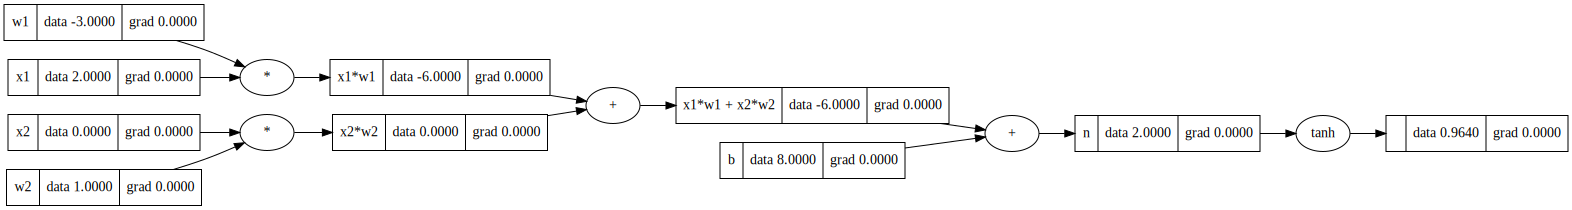

In [142]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(8, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
# draw_dot(n)
draw_dot(o)

Example 3 by changing the bias to see the impact of tanh

In [143]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)


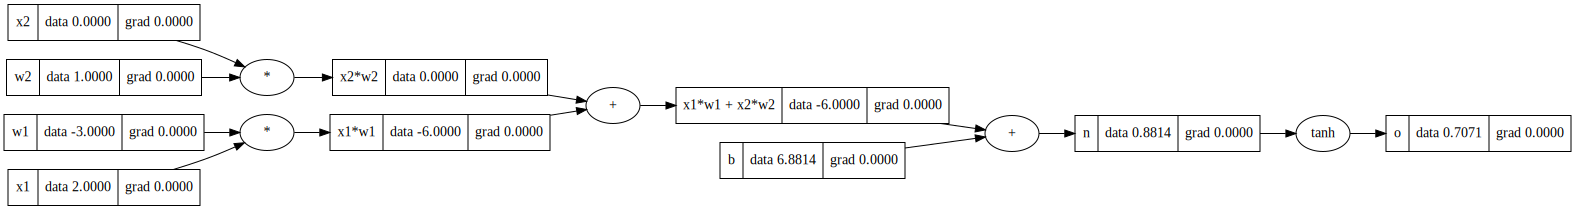

In [144]:
draw_dot(o)

In [145]:
o.grad = 1

if $o = tanh(n)$, then what is the $\frac{do}{dn} = 1- tanh(n)^2 = 1 - o^2$

In [146]:
1 - o.data**2 

0.4999999999999999

In [147]:
n.grad = 0.5

In [148]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [149]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [150]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [151]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

Automation of the backpropation in the `class Value`

In [152]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward()
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward()
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward()  
    return out

In [153]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

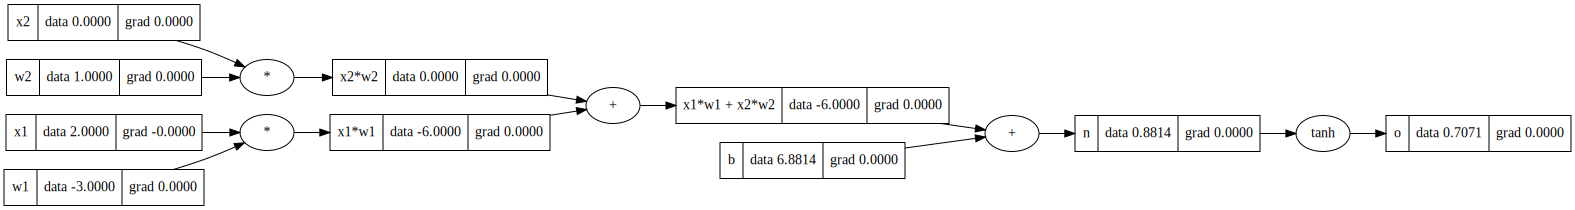

In [154]:
draw_dot(o)

In [155]:
o.grad = 1.0

Uncomment this to get an error and see what is wrong in the definiton of the `Value` class

In [156]:
# o.backward() # What is happening? if you go back to the class Value, we defined out._backward = _backward() --> this returns empty. 

In [157]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward  
    return out

In [158]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

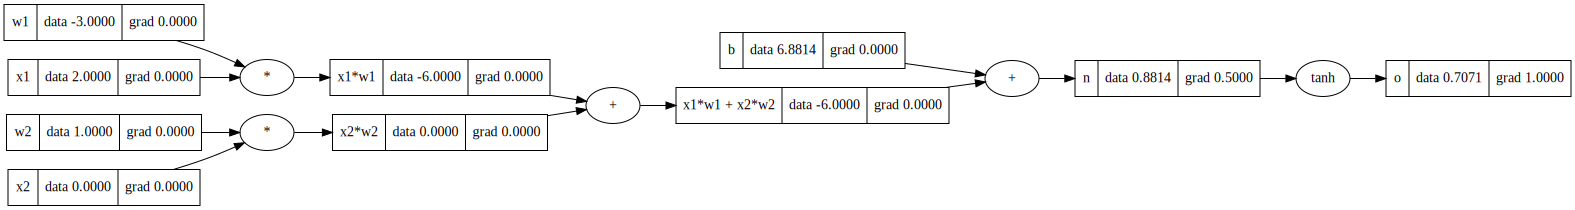

In [159]:
o.grad = 1.0
o._backward()
draw_dot(o)

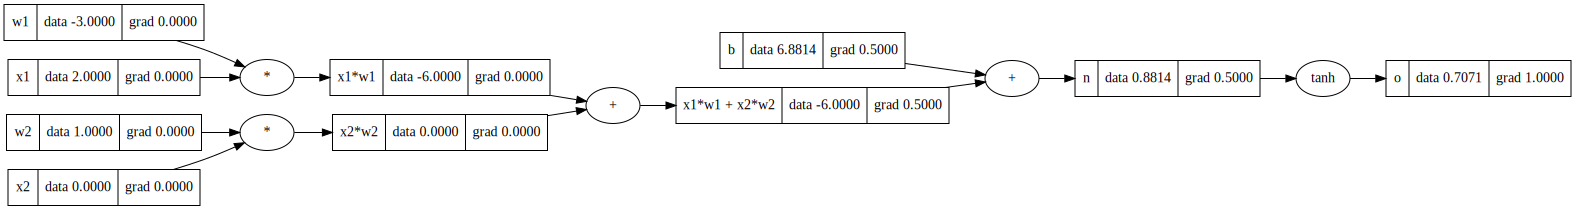

In [160]:
n._backward()
draw_dot(o)

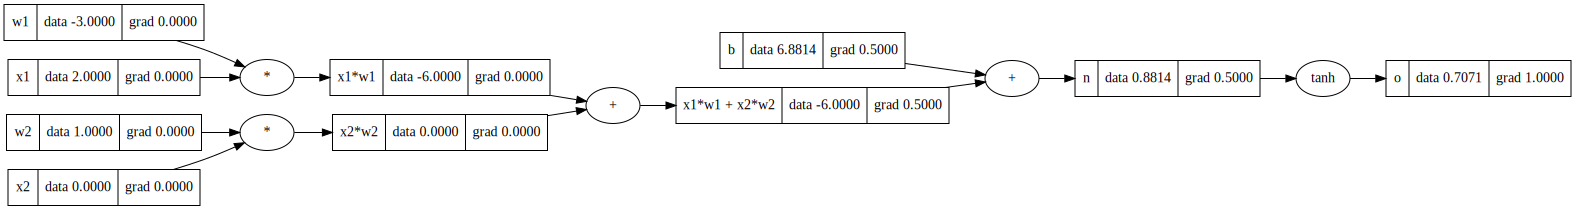

In [161]:
b._backward()
draw_dot(o)

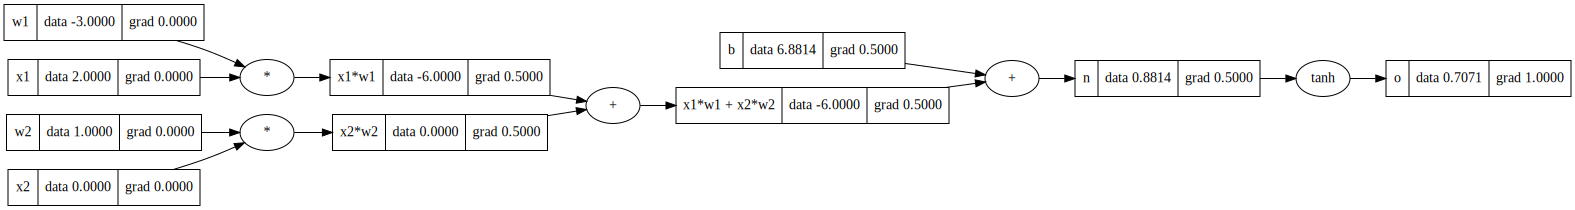

In [162]:
x1w1x2w2._backward()
draw_dot(o)

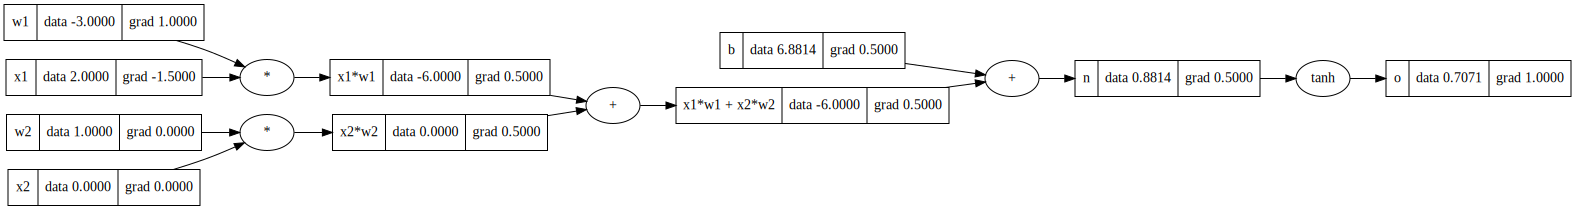

In [163]:
x1w1._backward()
draw_dot(o)

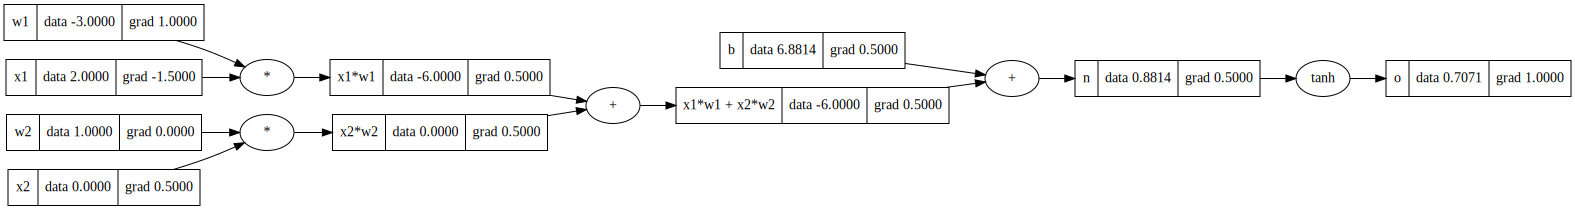

In [164]:
x2w2._backward()
draw_dot(o)

Build topological graph

In [165]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

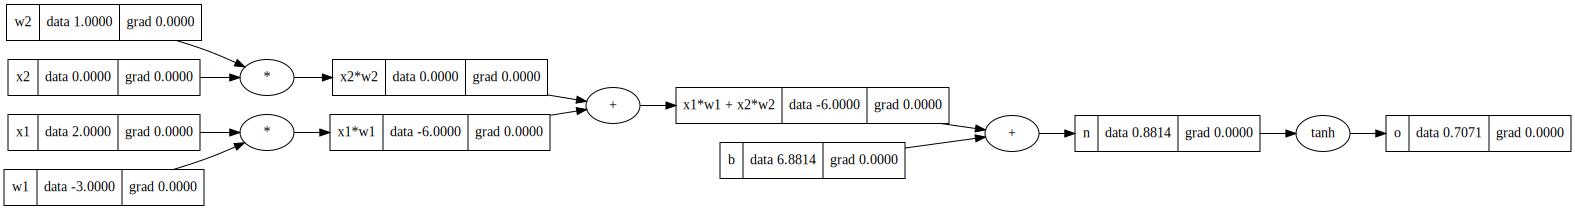

In [166]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

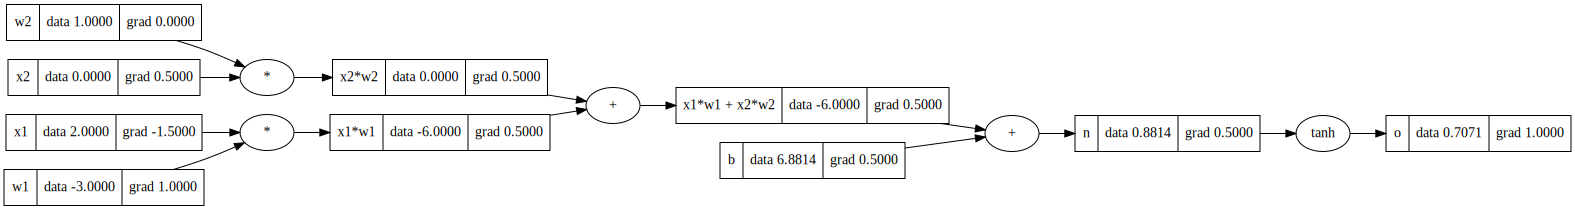

In [167]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


for node in reversed(topo):
  node._backward()

draw_dot(o)

**Adding the `build_topo` function in the `class Value`**

In [168]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward 
    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


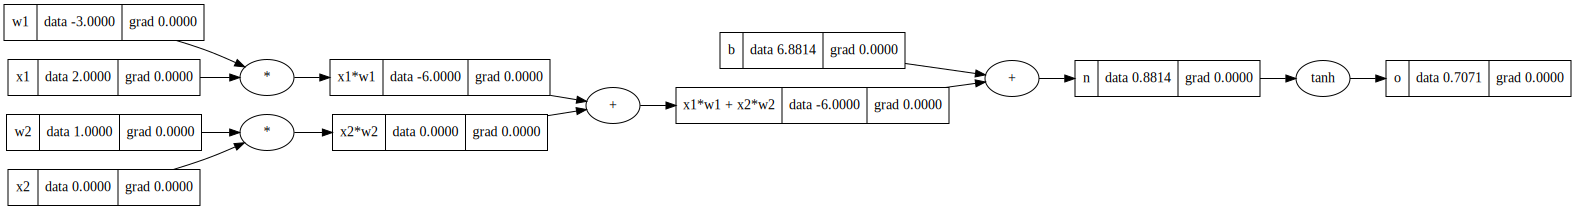

In [169]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

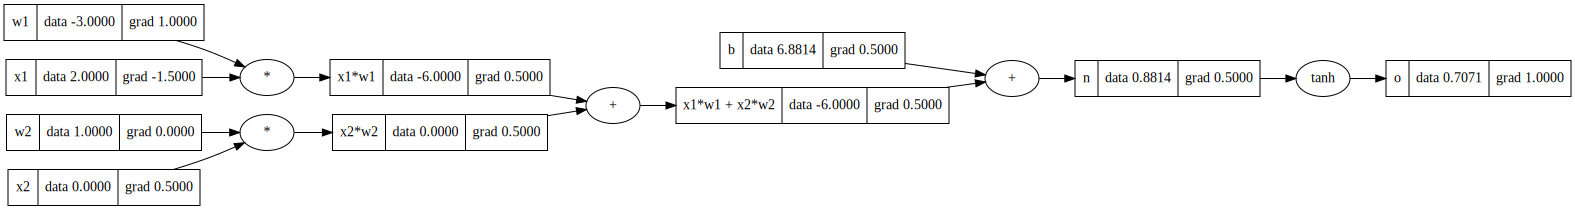

In [170]:
o.backward()
draw_dot(o)

There is a bug in the code. Let's see what is the bug?

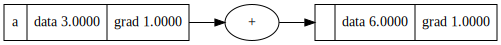

In [171]:
a = Value(3.0, label='a')
b = a + a; b.labeld = 'b'
b.backward()
draw_dot(b)

But $\frac{db}{da} = 2$, but we get $1$

Let's see this in a more complex example:

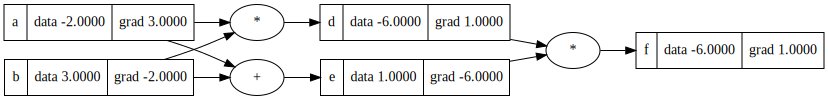

In [172]:
a = Value(-2.0, label='a')
b =  Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

We need to accumalate the gradients of the similar objects 

In [173]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward 
    return out

    
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

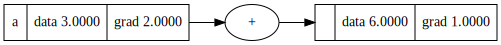

In [174]:
a = Value(3.0, label='a')
b = a + a; b.labeld = 'b'
b.backward()
draw_dot(b)

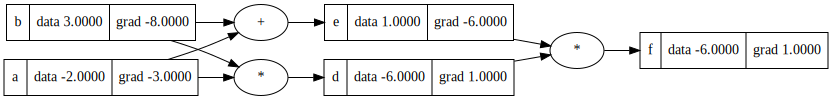

In [175]:
a = Value(-2.0, label='a')
b =  Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

Some other bugs!!With the current version of class Value, we can not  subtract, multiply, etc. a Value object with a number! Uncomment the cell below to see this!

In [182]:
# a = Value(2.0)
# a + 1

To fix this, we change the `class Value `as follows: (see [`isinstance`](https://www.w3schools.com/python/ref_func_isinstance.asp) for more details) 

In [183]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward 
    return out

    
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Now we can see that the above problem is solved now

In [184]:
a = Value(2.0)
print(a + 1)
print(a * 2)

Value(data=3.0)
Value(data=4.0)


Now what about `2 * a`? No!! We solve this as follow: 2.__mul__(a)

In [189]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self*other



  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward 
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward 
    return out

    
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [190]:
a = Value(2.0)
print(a + 1)
print(a * 2)
print(2 * a)
print(a.exp())

Value(data=3.0)
Value(data=4.0)
Value(data=4.0)
Value(data=7.38905609893065)


Now adding the division. `a / b` won't work now. Using the fact that: 
```
a/b = a*(1/b) = a * (b**-1) 
```

Check [here](https://www.w3schools.com/python/ref_keyword_assert.asp) for further details on the `assert` function

In [215]:
class Value:
  
  def __init__(self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0 # At the initialization, we assume that any values does not affect the Loss Function
    self._backward = lambda: None # By default this function does not do anything
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): 
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # self.grad = something
      # self.other = something
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  '''
  Check the power function and the gradient part later!! 
  '''
  def __pow__(self, other):
    assert isinstance(other, (int, float)) , "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data**(other -1)) * out.grad
      #other.grad += self.data**other.data * (math.log(self.data))
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self/other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward 
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward 
    return out

    
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [204]:
a = Value(2.0)
b = Value(4.0)
print(a/b)
print(a-b)
print(a**2)

Value(data=0.5)
Value(data=-2.0)
Value(data=4.0)


In [216]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

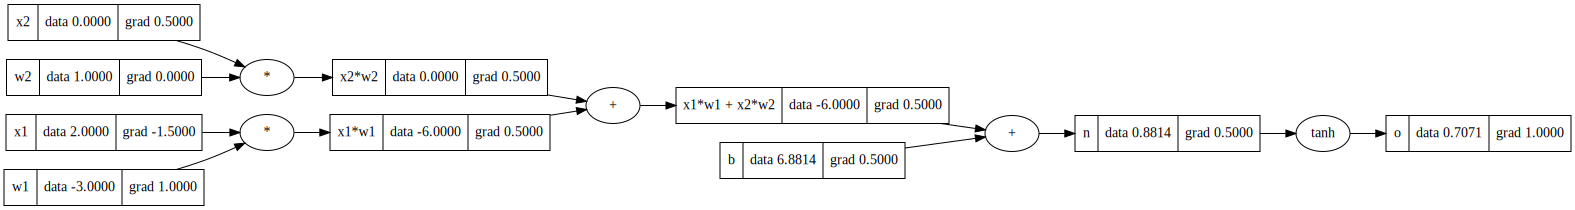

In [207]:
draw_dot(o)

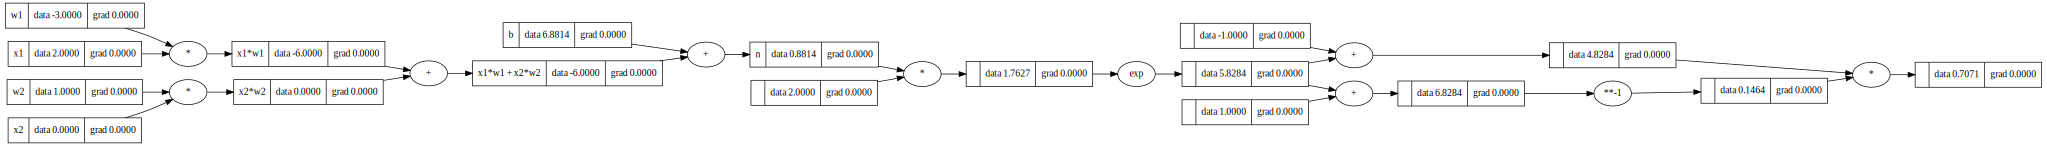

In [217]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (triger to make the neuron happy!!!)
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
# o = n.tanh(); o.label = 'o'
# ----
# ----
e = (2*n).exp()
o = (e-1) / (e+1)
# ----

draw_dot(o)